In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2025/players.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_7.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_9.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_6.csv
/kaggle/input/nfl-big-data-bowl-2025/games.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_8.csv
/kaggle/input/nfl-big-data-bowl-2025/player_play.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_4.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv
/kaggle/input/nfl-big-data-bowl-2025/plays.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_2.csv


In [2]:
# This is where my own code starts

# Import the first two raw data files
plays_raw = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/plays.csv')
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/games.csv')

# Add the game by game info to the play data
plays = pd.merge(plays_raw, games, on='gameId', how='left')
plays.columns

# Add the player-specific info
players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/players.csv')
player_play = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/player_play.csv')

# Testing with the Week 1-3 tracking data
track_1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv')
track_1['Week'] = 1


In [4]:
track_2 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_2.csv')
track_2['Week'] = 2

#track_3 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv')
#track_3['Week'] = 3

#track_4 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv')
#track_4['Week'] = 4

track_1_2 = pd.concat([track_1, track_2], axis=0).reset_index(drop=True)
#track_1_3 = pd.concat([track_1, track_2, track_3], axis=0).reset_index(drop=True)
#track_1_4 = pd.concat([track_1, track_2, track_3, track_4], axis=0).reset_index(drop=True)


In [5]:
testing_df = track_1_2


In [6]:
# Link the players df so we can tell what position the motion comes from
testing_df = pd.merge(testing_df, players[['position','nflId']], on='nflId', how='left')

# Add an indicator for offense or defense (special teams not included)

offense_pos = ['QB', 'WR', 'RB', 'TE', 'C', 'G', 'T', 'FB']
defense_pos = ['DT', 'NT', 'DE', 'CB', 'FS', 'SS', 'ILB', 'MLB', 'OLB']

testing_df['pos_type'] = np.where(testing_df['position'].isin(offense_pos), 'O', 'D')

We want to take the player tracking data, which shows each player's frame-by-frame movements, and link it with the play-by-play data. This will allow us to see what the outcome of the play was.

In [28]:
# Filtering offense data
all_offense = testing_df[testing_df['pos_type'] == 'O']

# Merge this dataframe with the Player Plays table, showing motion, route, etc. indicators
link_cols = ['gameId', 'playId', 'nflId']
add_cols = ['inMotionAtBallSnap', 'motionSinceLineset', 
            'shiftSinceLineset','wasRunningRoute'] # TWO TYPES OF MOTION: at the snap, and any time pre-snap

all_offense = pd.merge(all_offense, player_play[link_cols + add_cols], \
                           on = link_cols)

# Make new columns for the player IDs that go in motion/shift/routes, so we can find the number of unique ones for each play
all_offense['playerMotion'] = np.where(all_offense['motionSinceLineset'] == True, all_offense['nflId'], "")
all_offense['playerShift'] = np.where(all_offense['shiftSinceLineset'] == True, all_offense['nflId'], "")
all_offense['playerSnapMotion'] = np.where(all_offense['inMotionAtBallSnap'] == True, all_offense['nflId'], "")
all_offense['playerRoute'] = np.where((all_offense['motionSinceLineset'] == True) & (all_offense['wasRunningRoute'] == True), all_offense['nflId'], "")

In [52]:
def find_motions_and_routes(tracking_data):
    ''' 
    Find the number of players that went in motion on a play.
    We're also going to filter for only passing plays.
    Also find the number of these players who ran routes.
    Input dataframe needs to have the columns identifying the 
    unique game, play, and player, and needs to have an indicator
    for motion for each player'''
    
    tracking_data = pd.merge(tracking_data, plays[['playId', 'gameId', 'passResult']], 
                             on=['playId', 'gameId'], how='left')
    
    # Get only passing plays (non-passing ones will have NaN as the value for this col)
    tracking_data = tracking_data[tracking_data['passResult'].notna()]
    
    motion_players = (
        tracking_data.groupby(['playId', 'gameId'])[['playerMotion','playerShift','playerSnapMotion','playerRoute']]
        .nunique()
        .reset_index()
    )

    motion_players.columns = ['playId', 'gameId', 'uniqueMotionPlayers', 'uniqueShiftPlayers', 'uniqueSnapMotionPlayers', 'motionsAndRoutes']
    
    # Since the empty string "" counts as a unique value, subtract 1 from each entry
    motion_players['uniqueMotionPlayers'] -= 1
    motion_players['uniqueSnapMotionPlayers'] -= 1
    motion_players['uniqueShiftPlayers'] -= 1
    motion_players['motionsAndRoutes'] -= 1
    
    motion_players['anyMotion'] = motion_players['uniqueMotionPlayers'] >= 1
    motion_players['anySnapMotion'] = motion_players['uniqueSnapMotionPlayers'] >= 1
    motion_players['anyShift'] = motion_players['uniqueShiftPlayers'] >= 1


    return motion_players, tracking_data

all_motion_players, all_offense = find_motions_and_routes(all_offense)
all_motion_players
#all_offense.columns

,playId,gameId,uniqueMotionPlayers,uniqueShiftPlayers,uniqueSnapMotionPlayers,motionsAndRoutes,anyMotion,anySnapMotion,anyShift
0,56,2022090800,1,0,0,1,True,False,False
1,56,2022091802,0,0,0,0,False,False,False
2,56,2022091804,0,0,0,0,False,False,False
3,56,2022091807,1,0,0,1,True,False,False
4,56,2022091810,1,0,0,1,True,False,False
...,...,...,...,...,...,...,...,...,...
2325,5015,2022091103,0,0,0,0,False,False,False
2326,5039,2022091103,0,0,0,0,False,False,False
2327,5074,2022091103,0,0,0,0,False,False,False
2328,5096,2022091103,0,0,0,0,False,False,False


In [40]:
plays['possTeamScore'] = np.where(plays['possessionTeam'] == plays['homeTeamAbbr'],
                                  plays['preSnapHomeScore'],
                                  plays['preSnapVisitorScore'])
plays['nonpossTeamScore'] = np.where(plays['possessionTeam'] == plays['homeTeamAbbr'],
                                  plays['preSnapVisitorScore'],
                                  plays['preSnapHomeScore'])

The following section will be very important: this is how we determine which plays to categorize as 'hurry up' plays. Right now I've defined it as any situation where the possession team is trailing in a one score game in the fourth quarter, but it needs to be more refined. If a team takes a timeout before a play, they wouldn't be in a hurry-up situation anymore. Also, the time remaining in the quarter is important: teams are more likely to be in hurry-up with one minute left in the second quarter than with ten minutes left in the fourth. Could look at actual time between end of the last play and start of the next, or look at the 'huddle_break_offense' indicator in the 'event' column of the tracking data.

In [41]:
def find_hurry_up(play_data):
    ''' 
    This should take a df of all pbp data and return the situations
    where there's a time constraint for the losing team, hence the need for
    hurry up. We should also look at the times where they *actually* ran
    hurry up, but this is a placeholder for now.
    '''
    
    hu_conditions = [
        play_data['quarter'] == 4, # fourth quarter (should also include second)
        play_data['possTeamScore'] - play_data['nonpossTeamScore'] < 0, # poss team losing
        play_data['possTeamScore'] - play_data['nonpossTeamScore'] >= -8 # one score game
    ] 

    play_data['hurryUp'] = np.where(np.logical_and.reduce(hu_conditions), True, False)

    return play_data
          
plays_new = find_hurry_up(plays)


In [42]:
# Merge the hurry up indicator with the tracking data, then find the motion numbers
all_offense_with_hu = pd.merge(all_offense, plays_new[['gameId','playId','hurryUp']], on=['gameId','playId'], how='left')

#no_huddle_motions = find_motions_and_routes(all_offense_with_hu[all_offense_with_hu['hurryUp']])

In [36]:
# Find frequency of motion in no huddle situations vs normal
print(np.average(all_motion_players['anyMotion']))
#print(np.average(no_huddle_motions['anyMotion']))

print(np.average(all_motion_players['anySnapMotion']))

0.4695278969957081
0.25278969957081543


In [46]:
# THIS IS NOW ONLY FOR PASSING PLAYS

with_motions = pd.merge(plays, all_motion_players, on=['gameId', 'playId'])
with_motions.groupby(['uniqueMotionPlayers','hurryUp']).agg(
    meanEPA=('expectedPointsAdded', 'mean'),
    count_all=('uniqueMotionPlayers', 'count')
).reset_index()

# Find each team's success with motion and without motion
team_by_team = with_motions.groupby(['possessionTeam']).agg(
    averageMotion=('uniqueMotionPlayers', 'mean'),
    averageMotionandRoute=('motionsAndRoutes', 'mean'),
    meanEPA=('expectedPointsAdded', 'mean'),
    count_all=('possessionTeam', 'count')
).reset_index()

# Somewhat significant correlation between teams' motion rates and EPA, which is good
print(team_by_team['averageMotion'].corr(team_by_team['meanEPA']))
#team_by_team['averageMotionandRoute'].corr(team_by_team['meanEPA'])

team_by_team

0.3187910910596119


,possessionTeam,averageMotion,averageMotionandRoute,meanEPA,count_all
0,ARI,0.250000,0.250000,0.007036,88
1,ATL,0.776119,0.597015,-0.129073,67
2,BAL,0.852459,0.573770,0.303018,61
3,BUF,0.554054,0.472973,0.474911,74
4,CAR,0.640625,0.562500,-0.212792,64
5,CHI,0.487179,0.333333,-0.219708,39
6,CIN,0.355556,0.266667,-0.169953,90
7,CLE,0.920635,0.761905,0.070375,63
8,DAL,0.506667,0.493333,-0.289939,75
9,DEN,0.447368,0.447368,0.233498,76


In [ ]:
# Personnel groupings

by_alignment = with_motions.groupby(['receiverAlignment', 'hurryUp', 'anyMotion']).agg(
    averageEPA=('expectedPointsAdded', 'mean'),
    count_all=('expectedPointsAdded', 'size')
).reset_index()

# Filter for the most common alignments
by_alignment = by_alignment[by_alignment['receiverAlignment'].isin(['1x1', '2x1', '2x2', '3x1', '3x2', '4x1'])]


# Calculate the difference in EPA in each alignment based on whether there's motion or not
diffs = []
for i in np.unique(by_alignment['receiverAlignment']):
    for j in [True, False]:
        for k in [True, False]:
            try:
                diffs.append([i + str(j) + str(k), 
                  by_alignment[(by_alignment['receiverAlignment'] == i) & 
                               (by_alignment['anyMotion'] == j) & 
                               (by_alignment['hurryUp'] == k)].iloc[0][['averageEPA', 'count_all']]])
            except:
                continue

#by_alignment[(by_alignment['receiverAlignment'] == '1x1') & 
                               #(by_alignment['anyMotion'] == True) & 
                               #(by_alignment['hurryUp'] == False)].iloc[0][['averageEPA', 'count_all']]


#diffs
pd.DataFrame(diffs)
#np.mean(with_motions['expectedPointsAdded'])

#by_alignment

In [ ]:
# Separate by type of defensive coverage
#with_motions = pd.merge(plays, all_motion_players, on=['gameId', 'playId'])

with_motions[with_motions['pff_manZone'].isin(['Man', 'Zone'])].groupby(
    ['pff_manZone', 'hurryUp', 'anySnapMotion']).agg(
    meanEPA = ('expectedPointsAdded', 'mean'),
    averageYards = ('prePenaltyYardsGained', 'mean'), # does it make sense to include penalty yards?
    count = ('expectedPointsAdded', 'count')).reset_index()

In [ ]:
in_motion = all_offense[all_offense['motionSinceLineset'] == True]

in_motion = in_motion[['gameId', 'playId', 'nflId', 'displayName', 'frameType',
                      'time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event','position']]

print((in_motion[['gameId', 'playId', 'nflId']].drop_duplicates()))

# This is to set up a plot with each player's movement (below)

jeudy = in_motion[(in_motion['playId'] == 401) & (in_motion['nflId'] == 52423) & (in_motion['gameId'] == 2022091200)]# & (in_motion['frameType'] == 'AFTER_SNAP')]
#fant = in_motion[(in_motion['playId'] == 401) & (in_motion['nflId'] == 47803) & (in_motion['gameId'] == 2022091200)]# & (in_motion['frameType'] == 'AFTER_SNAP')]
wilson = all_offense[(all_offense['playId'] == 401) & (all_offense['nflId'] == 38605) & (all_offense['gameId'] == 2022091200)]# & (all_offense['frameType'] == 'AFTER_SNAP')]
sutton = all_offense[(all_offense['playId'] == 401) & (all_offense['nflId'] == 46109) & (all_offense['gameId'] == 2022091200)]# & (all_offense['frameType'] == 'AFTER_SNAP')]
center = all_offense[(all_offense['playId'] == 401) & (all_offense['nflId'] == 52491) & (all_offense['gameId'] == 2022091200)]# & (all_offense['frameType'] == 'AFTER_SNAP')]

In [56]:
#all_offense[(all_offense['gameId'] == 2022091200)].drop_duplicates('playId')
#plays[(plays['gameId'] == 2022091200) & (plays['playId'] == 64)][['playDescription', 'passResult']]

off_small = all_offense.drop(columns=['frameId','jerseyNumber','club', 'playDirection',
                                     'dis', 'o', 'dir', 'Week', 'pos_type', 'playerMotion',
                                     'playerSnapMotion', 'playerRoute'])

off_small = pd.merge(off_small, plays[['gameId', 'playId', 'passResult']],
                                           on = ['gameId', 'playId'], how='left')

In [57]:
# Find the time elapsed between line set, motion, and ball snap
#all_offense = all_offense[all_offense['passResult'].notna()]

motion_events = ['line_set', 'man_in_motion', 'ball_snap']

event_times = off_small[(off_small['event'].isin(motion_events))].drop_duplicates(
    ['gameId', 'playId', 'event'])[['gameId', 'playId', 'event', 'time']]

# Add milliseconds if absent
event_times['time'] = event_times['time'].apply(lambda x: x if '.' in x else x + '.0')

event_times['time'] = pd.to_datetime(event_times['time'])


time_diffs = event_times.pivot(index=['gameId', 'playId'], columns='event', values='time').assign(
    set_to_motion=lambda x: (x['man_in_motion'] - x['line_set']).dt.total_seconds(), 
    motion_to_snap=lambda x: (x['ball_snap'] - x['man_in_motion']).dt.total_seconds()
).dropna().reset_index()

#time_diffs[time_diffs['set_to_motion'] < 0]
time_diffs = pd.merge(time_diffs, 
                      all_motion_players[['gameId', 'playId', 'anyMotion','anyShift', 'anySnapMotion']], 
                      on=['gameId', 'playId'], 
                      how='left')

#time_diffs[(time_diffs['anyMotion'] == False) & (time_diffs['anySnapMotion'] == False) & (time_diffs['anyShift'] == False)].shape
time_diffs

['C' 'I' 'IN' 'R' 'S']


,gameId,playId,ball_snap,line_set,man_in_motion,set_to_motion,motion_to_snap,anyMotion,anyShift,anySnapMotion
0,2022090800,80,2022-09-09 00:24:33.200,2022-09-09 00:24:26.700,2022-09-09 00:24:30.500,3.8,2.7,True,False,True
1,2022090800,212,2022-09-09 00:28:20.500,2022-09-09 00:28:18.000,2022-09-09 00:28:19.600,1.6,0.9,True,False,True
2,2022090800,236,2022-09-09 00:29:00.100,2022-09-09 00:28:55.900,2022-09-09 00:28:59.200,3.3,0.9,True,False,True
3,2022090800,364,2022-09-09 00:35:12.000,2022-09-09 00:35:00.800,2022-09-09 00:35:04.600,3.8,7.4,True,False,False
4,2022090800,438,2022-09-09 00:36:55.800,2022-09-09 00:36:51.500,2022-09-09 00:36:55.100,3.6,0.7,True,False,True
...,...,...,...,...,...,...,...,...,...,...
667,2022091901,2635,2022-09-20 02:24:41.100,2022-09-20 02:24:36.600,2022-09-20 02:24:39.600,3.0,1.5,False,False,True
668,2022091901,2706,2022-09-20 02:27:23.500,2022-09-20 02:27:17.900,2022-09-20 02:27:19.100,1.2,4.4,False,True,False
669,2022091901,3002,2022-09-20 02:39:54.500,2022-09-20 02:39:48.900,2022-09-20 02:39:54.300,5.4,0.2,False,False,True
670,2022091901,3444,2022-09-20 02:55:59.200,2022-09-20 02:55:53.800,2022-09-20 02:55:54.900,1.1,4.3,True,False,False


-0.018948874225670067


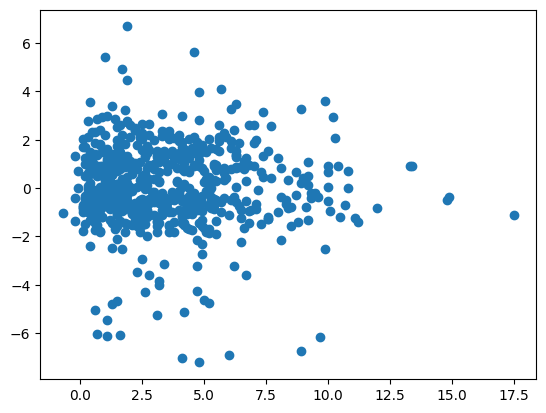

In [60]:
times_and_EPA = pd.merge(time_diffs, plays[['gameId', 'playId', 'expectedPointsAdded', 'prePenaltyYardsGained']], on=['gameId', 'playId'], how='left')

print(times_and_EPA['motion_to_snap'].corr(times_and_EPA['expectedPointsAdded']))
plt.scatter(times_and_EPA['motion_to_snap'], times_and_EPA['expectedPointsAdded'])
#plt.xlim(0,20)

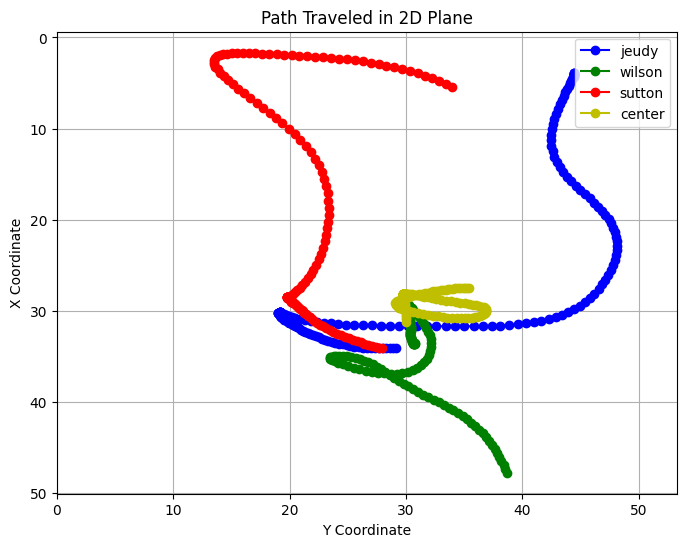

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(jeudy['y'], jeudy['x'], marker='o', linestyle='-', color='b', label="jeudy")
plt.plot(wilson['y'], wilson['x'], marker='o', linestyle='-', color='g', label="wilson")
plt.plot(sutton['y'], sutton['x'], marker='o', linestyle='-', color='r', label="sutton")
plt.plot(center['y'], center['x'], marker='o', linestyle='-', color='y', label="center")
#plt.plot(penny['y'], penny['x'], marker='o', linestyle='-', color='brown', label="penny")

plt.title("Path Traveled in 2D Plane")
plt.xlabel("Y Coordinate")
plt.ylabel("X Coordinate")
plt.xlim(0, 53.3)
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()